<a href="https://colab.research.google.com/github/tzoung-yu/TrueVolume/blob/main/%E4%B8%8A%E5%B8%82_%E9%82%84%E5%8E%9F%E7%B7%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4967 十銓 上市 半導體業
統計起始日:2022/10/01
[*********************100%%**********************]  1 of 1 completed
2023-11-03
 91.9
月: True 週: True 日: True


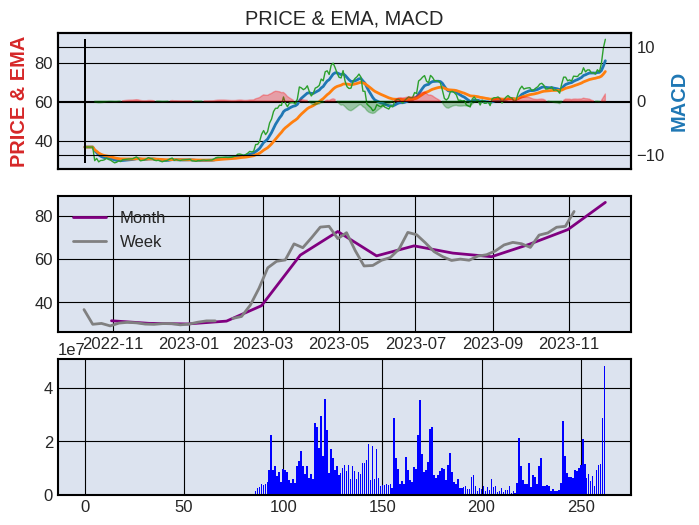

In [9]:
!pip install twstock
#!pip install mplfinance
#!twstock -U
import twstock
from twstock import Stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import matplotlib as mpl
import yfinance as yf
#import mplfinance as mpf

#股票代號
stoid='十銓'

thisday = datetime.today()
day_start = thisday - timedelta(days=400)
draw_start = thisday - timedelta(days=400)
#day_start = thisday.replace(month=1, day=1)
adj=[]

mpl.rcParams["figure.figsize"] = (7.4, 6)

def TrueVol(pd):
  df=pd
  global thisday
  global draw_start
  end_date = thisday
  start_date = draw_start
  df = df[df['Date'].between(start_date, end_date)]
  df = df.reset_index(drop=False)
  clo=df['Close']

  x=np.arange(len(clo))
  ema10=clo.ewm(span=9).mean()
  ema30=clo.ewm(span=26).mean()

  exp12     = clo.ewm(span=12, adjust=True).mean()
  exp26     = clo.ewm(span=26, adjust=True).mean()
  macd      = exp12 - exp26
  signal    = macd.ewm(span=9, adjust=True).mean()
  histogram = macd - signal

  df1 = pd.set_index('Date')
  # 計算月線EMA
  mEma12 = df1['Close'].resample('M').mean().ewm(span=12, adjust=True).mean()
  mEma26 = df1['Close'].resample('M').mean().ewm(span=26, adjust=True).mean()
  mMacd = mEma12 - mEma26
  mSignal = mMacd.ewm(span=9, adjust=True).mean()
  mHisto = mMacd-mSignal
  # 計算週線EMA
  wEma12 = df1['Close'].resample('W').mean().ewm(span=12, adjust=True).mean()
  wEma26 = df1['Close'].resample('W').mean().ewm(span=26, adjust=True).mean()
  wMacd = wEma12 - wEma26
  wSignal = wMacd.ewm(span=9, adjust=True).mean()
  wHisto = wMacd-wSignal

  MUP=False
  if mHisto.iloc[-1]>0:
    MUP = True
  WUP=False
  if wHisto.iloc[-1]>0:
    WUP = True
  DUP=False
  if histogram.iloc[-1]>0:
    DUP = True

  print('月:',MUP,'週:',WUP,'日:',DUP)

  ax1 = plt.subplot(311)
  ax2 = ax1.twinx()
  ax1.set_ylabel('PRICE & EMA', color='tab:red')
  ax2.set_ylabel('MACD', color='tab:blue')
  ax1.plot(ema10)
  ax1.plot(ema30)
  ax1.plot(clo,linewidth=1)
  ax2.fill_between(x, histogram, where=(histogram<0), color='green', alpha=0.3)
  ax2.fill_between(x, histogram, where=(histogram>0), color='red', alpha=0.3)
  mm = max(abs(histogram))*5
  xx = [0, 0]
  h = [0-mm, mm]
  plt.bar(xx, height=h, color='black',linewidth=0)
  plt.title('PRICE & EMA, MACD')
  plt.gca().xaxis.set_ticks([])
  plt.grid(color='black')

  plt.subplot(312)
  plt.plot(df1['Close'].resample('M').mean(), color='purple', label='Month')
  plt.plot(df1['Close'].resample('W').mean(), color='gray', label='Week')
  plt.legend()

  plt.subplot(313)
  x=np.arange(0,len(clo))
  plt.bar(x, height=df['Volume'], color='blue',linewidth=0)

  '''df = df.set_index("Date")
  apds = [
          mpf.make_addplot(ema10,secondary_y=False,color='b'),
          mpf.make_addplot(ema30,secondary_y=False,color='orange'),
          mpf.make_addplot(histogram,type='bar',width=0.7,panel=1,
                         color='c',alpha=1,secondary_y=False),
         ]

  color=mpf.make_marketcolors(up='red', down='green', inherit=True)
  style1=mpf.make_mpf_style(base_mpf_style='default', gridcolor='black', marketcolors=color)

  mpf.plot(df,type='candle',addplot=apds, figscale=1,figratio=(7,4),title='\n'+stoid+'--EMA & MACD',
                     style=style1,volume=True, volume_panel=2,panel_ratios=(6,3,3),returnfig=True)'''
  plt.show()

def keep_first_line(text):
    lines = text.splitlines()
    if lines:
        return lines[0]
    else:
        return ""

codes = twstock.codes
df = pd.DataFrame.from_dict(codes, orient='index')

stoname=str(stoid)
if not stoname.isdigit():
  nn = df[df["name"] == stoname]
  stoid=str(int(nn.code.iloc[0]))

nn=df[df["code"]==stoid]
print(stoid, nn.name[0], nn.market[0],nn.group[0])

# 讀取股價資料
if(nn.market[0]=='上市'):
  print("統計起始日:"+draw_start.strftime("%Y/%m/%d"))
  data1 = yf.download(stoid+'.TW',start=day_start, end=thisday)
  data1 = data1.reset_index(drop=False)
  adj=data1['Adj Close']-data1['Close']
  data1['High']+=adj
  data1['Low']+=adj
  data1['Open']+=adj
  data1 = data1.drop(['Close'], axis=1)
  data1 = data1.rename(columns={'Adj Close': 'Close'})

  df=data1.tail(1)
  tt1=str(df["Date"])
  tt1= keep_first_line(tt1)
  print(tt1[-10:])
  tt1=str(round(df["Close"],2))
  tt1= keep_first_line(tt1)
  print(tt1[6:])

  TrueVol(data1)
else:
  print("非上市類型 無法繪製還原線")